Processing Level 1
Processing Level 2
Processing Level 3
Processing Level 4
Processing Level 5
Processing Level 6


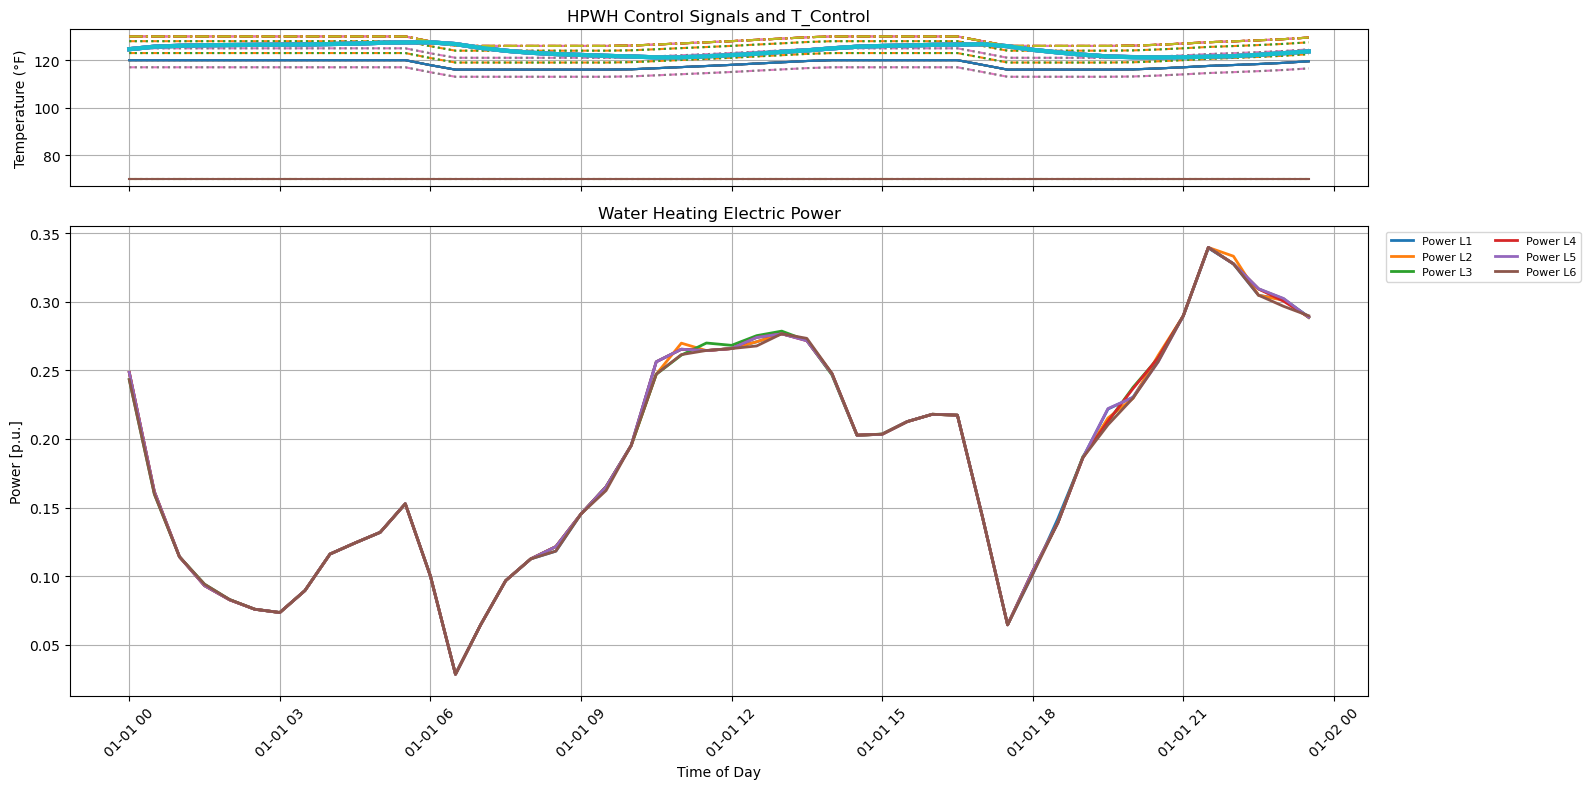

All requested levels processed and plotted in Fahrenheit!


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------------
# USER SETTINGS
# -------------------------------
WORKING_DIR = r"C:\Users\danap\OCHRE_Working"
LEVEL_START = 1  # minimum level to plot
LEVEL_END = 6    # maximum level to plot

# Columns
Ttrue_col   = "Water Heating Control Temperature (C)"
power_col   = "Water Heating Electric Power (kW)"
control_cols = ["ER_ON", "ER_OFF", "HP_ON", "HP_OFF"]

# Parameters
Prated = 0.5
N_homes = 409
days = 1
N = N_homes * Prated * days  # normalization factor

# -------------------------------
# FUNCTIONS
# -------------------------------
def c_to_f(temp_c):
    """Convert Celsius to Fahrenheit"""
    return temp_c * 9/5 + 32

def process_dataset(path):
    df_raw = pd.read_parquet(path)
    if 'Time' in df_raw.columns:
        df_raw['Time'] = pd.to_datetime(df_raw['Time'])
        df_raw.set_index('Time', inplace=True)
    df_raw["time_of_day"] = df_raw.index.time
    return df_raw

def time_of_day_to_datetime(idx):
    ref_date = datetime(2000,1,1)
    return [ref_date.replace(hour=t.hour, minute=t.minute, second=0) for t in idx]

# -------------------------------
# INITIALIZE FIGURE
# -------------------------------
fig, (ax_ctrl, ax_power) = plt.subplots(2,1, figsize=(16,8), sharex=True,
                                        gridspec_kw={'height_ratios':[1,3]})

# Use gnuplot2 colormap
n_levels = LEVEL_END - LEVEL_START + 1
# colors = ['red', 'blue', 'orange', 'green', 'yellow', 'purple', 'black', 'lightblue']

# -------------------------------
# LOOP OVER LEVELS
# -------------------------------
for i, level in enumerate(range(LEVEL_START, LEVEL_END + 1)):
    filename = f"180110_1_30_Efficiency_Level{level}_Control.parquet"
    # filename = f"180407_1_15_xx_Level{level}_Control2.parquet"
    CONTROLLED_FILE = os.path.join(WORKING_DIR, filename)

    if not os.path.exists(CONTROLLED_FILE):
        print(f"File not found: {CONTROLLED_FILE}, skipping Level {level}")
        continue

    print(f"Processing Level {level}")
    df_controlled = process_dataset(CONTROLLED_FILE)

    # Collapse to composite daily profile
    composite = {}
    # Convert temperatures to F
    composite['Power_Controlled'] = df_controlled.groupby("time_of_day")[power_col].sum() / N
    composite[Ttrue_col] = c_to_f(df_controlled.groupby("time_of_day")[Ttrue_col].mean())
    for c in control_cols:
        composite[c] = c_to_f(df_controlled.groupby("time_of_day")[c].mean())

    time_index = time_of_day_to_datetime(composite['Power_Controlled'].index)

    # --- Overlay control signals ---
    ax_ctrl.plot(time_index, composite['ER_ON'], label=f"ER_ON L{level}",  linestyle='-')
    ax_ctrl.plot(time_index, composite['ER_OFF'], label=f"ER_OFF L{level}", linestyle='--')
    ax_ctrl.plot(time_index, composite['HP_ON'], label=f"HP_ON L{level}", linestyle=':')
    ax_ctrl.plot(time_index, composite['HP_OFF'], label=f"HP_OFF L{level}",  linestyle='-.')

    # --- Overlay T_Control ---
    ax_ctrl.plot(time_index, composite[Ttrue_col], label=f"T_Control L{level}",  linewidth=3, linestyle='-')

    # --- Overlay power ---
    ax_power.plot(time_index, composite['Power_Controlled'], label=f"Power L{level}",  linewidth=2)

# -------------------------------
# FINALIZE PLOT
# -------------------------------
ax_ctrl.set_ylabel("Temperature (°F)")
ax_ctrl.set_title("HPWH Control Signals and T_Control")
ax_ctrl.grid(True)
# ax_ctrl.legend(fontsize=8, ncol=2, bbox_to_anchor=(1.01,1))

ax_power.set_ylabel("Power [p.u.]")
ax_power.set_xlabel("Time of Day")
ax_power.set_title("Water Heating Electric Power")
ax_power.grid(True)
ax_power.legend(fontsize=8, ncol=2, bbox_to_anchor=(1.01,1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("All requested levels processed and plotted in Fahrenheit!")


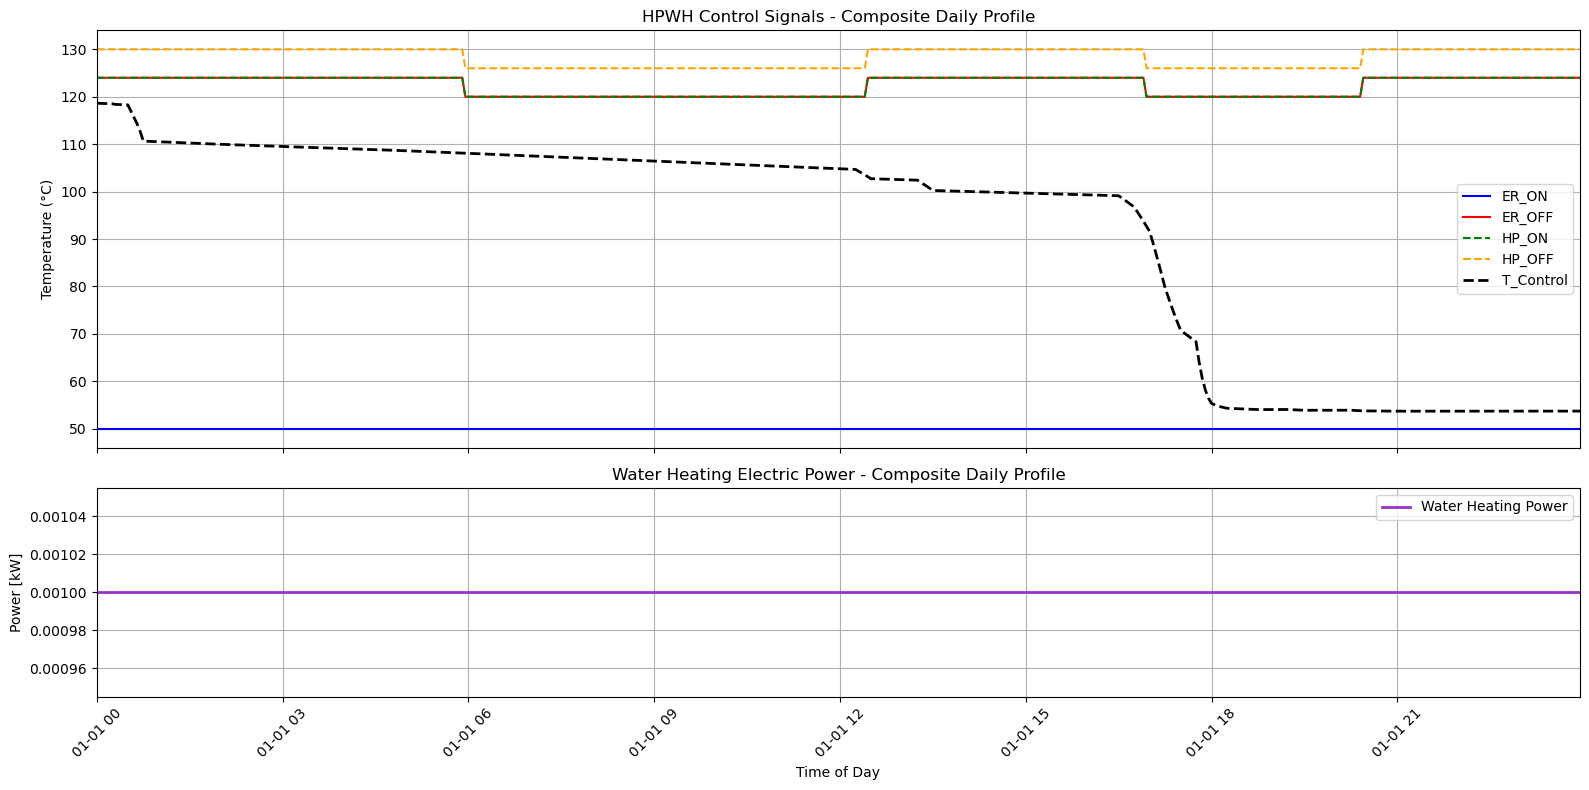

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------------
# USER SETTINGS
# -------------------------------
FILE_PATH = r"C:\Users\danap\OCHRE_Working\Input Files\bldg0007434-up06\Results\hpwh_controlled.parquet"
# Columns
Ttrue_col   = "Water Heating Control Temperature (C)"
power_col   = "Water Heating Electric Power (kW)"
control_cols = ["ER_ON", "ER_OFF", "HP_ON", "HP_OFF"]

# -------------------------------
# FUNCTIONS
# -------------------------------
def process_dataset(path):
    df = pd.read_parquet(path)
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    df['time_of_day'] = df.index.time
    return df

def time_of_day_to_datetime(idx):
    ref_date = datetime(2000,1,1)
    return [ref_date.replace(hour=t.hour, minute=t.minute, second=0) for t in idx]

# -------------------------------
# LOAD DATA
# -------------------------------
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"{FILE_PATH} does not exist!")

df_house = process_dataset(FILE_PATH)

# Collapse to composite by time of day (mean across days)
composite = {}
for col in control_cols + [Ttrue_col, power_col]:
    composite[col] = df_house.groupby('time_of_day')[col].mean()

time_index = time_of_day_to_datetime(composite[Ttrue_col].index)


def c2f(Tc):
    return 9/5 * Tc + 32

# -------------------------------
# PLOTTING
# -------------------------------
fig, (ax_ctrl, ax_power) = plt.subplots(2,1, figsize=(16,8), sharex=True,
                                        gridspec_kw={'height_ratios':[2,1]})

# Control signals
ax_ctrl.plot(time_index, c2f(composite['ER_ON']), label="ER_ON", color='blue')
ax_ctrl.plot(time_index, c2f(composite['ER_OFF']), label="ER_OFF", color='red')
ax_ctrl.plot(time_index, c2f(composite['HP_ON']), label="HP_ON", color='green', linestyle='--')
ax_ctrl.plot(time_index, c2f(composite['HP_OFF']), label="HP_OFF", color='orange', linestyle='--')

# Add control temperature
ax_ctrl.plot(time_index, c2f(composite[Ttrue_col]), label="T_Control", color='black', linewidth=2, linestyle='--')

ax_ctrl.set_ylabel("Temperature (°C)")
ax_ctrl.set_title("HPWH Control Signals - Composite Daily Profile")
ax_ctrl.legend()
ax_ctrl.grid(True)

# Power plot
ax_power.plot(time_index, composite[power_col], label="Water Heating Power", color='darkorchid', linewidth=2)
ax_power.set_ylabel("Power [kW]")
ax_power.set_xlabel("Time of Day")
ax_power.set_title("Water Heating Electric Power - Composite Daily Profile")
ax_power.set_xlim(time_index[0], time_index[-1])
ax_power.grid(True)
ax_power.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
